In [11]:
import xml.etree.ElementTree as ET
import os
import re
import time
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.stats import poisson,dirichlet, gamma
from scipy.special import logsumexp
from functools import reduce
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing.pool
import multiprocessing as mp

num_workers = mp.cpu_count() 
print(num_workers)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virenbajaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
8


In [539]:
def clean_data():
    with open("datasets/ap/ap.txt") as f:
        xml = f.read()
    # XML is not well formatted - it doesn't have ROOT tag 
    # Format XML to create one ROOT tag 
    xml_str = "<ROOT>" + xml + "</ROOT>"
    # Illegal '&' character has not been escaped. Escape it. 
    xml_str = re.sub(r"&", r"&#38;", xml_str) 
    # Parse xml tree 
    root = ET.fromstring(xml_str)
    # Load vocab
    vocab = np.loadtxt('datasets/ap/vocab.txt',dtype='str')
    datafile = 'datasets/ap/ap.dat'
    # data table for word counts of every doc
    data = np.zeros(shape=(len(root),len(vocab)),dtype=int) 
    with open(datafile) as f:
        for (i,line) in enumerate(f.readlines()):
            row = np.zeros(shape=(len(vocab)))
            for elem in line.split()[1:]: # Skip document count by indexing from 1
                split = elem.split(':')
                word,count = int(split[0]),int(split[1])
                row[word] = count
            data[i] = row
    df = pd.DataFrame(data,columns=vocab)
    # Drop stopwords from dataframe
    stopwords_set = set(stopwords.words('english'))
    dropcols = [stopword for stopword in stopwords_set if stopword in df.columns]
    df_ = df.drop(dropcols,axis=1)
    # Top words in data frame with frequency > N * std dev more than mean.
    total_counts_ = totalCounts(df_)
    mean, std = total_counts_.mean(), total_counts_.std()
    topwordsN = []
    N = 10
    for i, count in enumerate(total_counts_):
        if count > mean + N * std : 
            topwordsN.append(df_.columns[i])
    bottomwords = []
    low_freq = 50
    for i, count in enumerate(total_counts_):
        if count <= low_freq: 
    #         print(count,df_.columns[i])
            bottomwords.append(df_.columns[i])
    data_clean = df_.drop(topwordsN + bottomwords,axis=1)
    return data_clean

def totalCounts(df):
    "Return a Pandas Series of with the sum of every column of dataframe df"
    return (pd.Series([col.sum() for name,col in df.items()]))

def save_cp(cp_dir,phis,theta,zs,alphas,betas,lambdas,deviance, dev_only=False):
    "Save state of Gibbs sampler in cp_dir"
    if cp_dir is not None:
            if not os.path.exists(cp_dir):
                os.makedirs(cp_dir)
            if not dev_only:
                with open(f'{cp_dir}/phis.txt','a') as f:
                    np.savetxt(f,phis)
                with open(f'{cp_dir}/theta.txt','a') as f:
                    np.savetxt(f,theta)
                with open(f'{cp_dir}/zs.txt','a') as f:
                    np.savetxt(f,zs)
                with open(f'{cp_dir}/alphas.txt','a') as f:
                    np.savetxt(f,alphas)
                with open(f'{cp_dir}/betas.txt','a') as f:
                    np.savetxt(f,betas)
                with open(f'{cp_dir}/lambdas.txt','a') as f:
                    np.savetxt(f,lambdas)
            with open(f'{cp_dir}/deviance.txt','a') as f:
                f.write(str(deviance)+'\n')

In [540]:
# https://stackoverflow.com/questions/6974695/python-process-pool-non-daemonic
class NoDaemonProcess(multiprocessing.Process):
    @property
    def daemon(self):
        return False

    @daemon.setter
    def daemon(self, value):
        pass

class NoDaemonContext(type(multiprocessing.get_context())):
    Process = NoDaemonProcess

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class NestablePool(multiprocessing.pool.Pool):
    def __init__(self, *args, **kwargs):
        kwargs['context'] = NoDaemonContext()
        super(NestablePool, self).__init__(*args, **kwargs)

In [541]:
def gammaLogPdf(x,alpha,beta):
    "Return log pdf of gamma distribution at x with shape alpha, rate beta"
    return gamma.logpdf(x,alpha) + alpha*np.log(beta) + x*(1-beta)




In [630]:
class GibbsSampler:

    def __init__(self, data,K=3,alpha=1,beta=3,phi=1,cp=None):   
        self.data = data
        self.n_docs = len(data) # len of data
        self.n_words = len(data.columns) # size of vocab
        self.K = K
        self.phi = phi
        self.alpha = alpha
        self.beta = beta
#         self.num_workers = mp.cpu_count() 
        # Initialize latent variables
        if cp is not None:
            with open(cp,'rb') as f:
                states = pickle.load(f)
            # pick up where you left off 
            self.phis,self.theta,self.zs,self.alphas,self.betas,self.lambdas,deviance = states[-1]
        else:
            # 1. theta: uniform Dirichlet prior 
            
            self.phis = np.full((self.K,),self.phi)
            self.theta = np.random.dirichlet(self.phis) 
#             print("INTIAL THETA:", self.theta)
            # 2. zs: categorical z for choice between 0-K with probabilities = theta 
            self.zs = np.random.choice(self.K,p=self.theta,size=(self.n_docs,))
#             print("INTIAL zs:", np.unique(self.zs,return_counts=True))
            
            # 3. lambdas: Gamma(alpha,beta) prior with alpha(rate), beta(inverse scale) for each word in every doc 
            self.alphas = np.full((self.K,self.n_words), self.alpha) 
            self.betas = np.full((self.K,self.n_words), self.beta)
            self.lambdas = np.random.gamma(self.alpha,1/self.beta, size = (self.K,self.n_words))
    # Update latent variables based on complete conditionals. Also calculate deviance.
    # Define functions to parallelize within scope of data and latent variables to avoid passing them b/w processes

    
    def calcLogLikelihood(self,args):
        k = args[0]
        i = args[1]
        a = (poisson.logpmf(self.data.iloc[i],self.lambdas[k])) 
        return sum(a)

    def updateZ(self):
        # z update based on Eq 5.18
        for i in range(self.n_docs):
            args = [[k,i] for k in range(self.K)]       
            log_likelihood_i = list(map(self.calcLogLikelihood, args))
            theta_zi = np.log(self.theta) + log_likelihood_i # still in log space
            # normalize theta
            theta_zi = np.exp(theta_zi - logsumexp(theta_zi)) # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
            tmp = self.zs[i]
            self.zs[i] = np.random.choice(self.K, p=theta_zi) # draw new zi
            self.log_likelihood[i] = sum(log_likelihood_i) 

    
    def updateTheta(self,counts):
        # theta update based on Eq. 5.21
        for k,c in enumerate(counts):
            self.phis[k] = self.phi + c
        self.theta = np.random.dirichlet(self.phis) # draw new theta
    
    
    def countClusters(self):
        clusters = []
        counts = []
        for k in range(self.K):
            in_k = np.where(self.zs==k)
            clusters.append(in_k)
            counts.append(len(in_k))
        return clusters,counts
    
    
    def updateLambdas(self,clusters,counts):
        for k,cluster in enumerate(clusters):
            data_k = self.data.iloc[cluster] # data in cluster k
            self.alphas[k] = np.array(data_k.sum()) + self.alpha  
            self.betas[k] = counts[k] + self.beta
            self.lambdas[k] = np.random.gamma(self.alphas[k],1/self.betas[k]) # draw new lambdas 
            
    def run(self):
        while True: 
            self.log_likelihood = np.zeros(shape=(self.n_docs,))
            self.updateZ() # also calculates log_likelihood
            log_likelihood_sum = sum(self.log_likelihood) # = deviance part 4
            clusters, counts = self.countClusters()
            self.updateTheta(counts) # draw new theta
#             dirichlet_log = dirichlet.logpdf(theta,phis) # deviance part 1 - IGNORE
            # lambda update based on Eqs. 3.33,3.34
#             z_given_theta_log_sum = 0 # for deviance part 3 - IGNORE
            self.updateLambdas(clusters,counts)
            # deviance part 2
            gamma_log_sum = sum([sum([gammaLogPdf(self.lambdas[k,j],self.alphas[k,j],self.betas[k,j]) for j in range(self.n_words)]) for k in range(self.K)]) 
#                 z_given_theta_log_sum += cluster_dict[k]*np.log(theta[k]) # deviance part 3 - IGNORE
            deviance =  gamma_log_sum + log_likelihood_sum
#             print(f"""deviance = {deviance}, gamma_log_sum = {gamma_log_sum}, log_likelihood_sum = {log_likelihood_sum}""")

            yield self.phis,self.theta,self.zs,self.alphas,self.betas,self.lambdas,deviance 

In [566]:
data_clean = clean_data()
d_in = int(len(data_clean)*0.2)
print(d_in)
ab_init = np.array([[.1,.1],[2,.01],[.3,.1],[1,1]]) 
n_chains = len(ab_init)

449


In [571]:
def run_chain_wrapper(ab):
    a = ab[0]
    b = ab[1]
    GS = GibbsSampler(data_clean.iloc[:d_in],K=4,alpha=a,beta=b)
    GSChain = GS.run()
    n_iter = 50
    states = []
    for i in range(n_iter):
        t0 = time.time()
        state = next(GSChain)
#         print("state: ", state)
        states.append(state)
        t1 = time.time()
#         print("time = ",t1-t0, "\n")
    return states

In [573]:
with NestablePool(processes=num_workers) as pool:
    chains = list(pool.map(run_chain_wrapper, ab_init))    

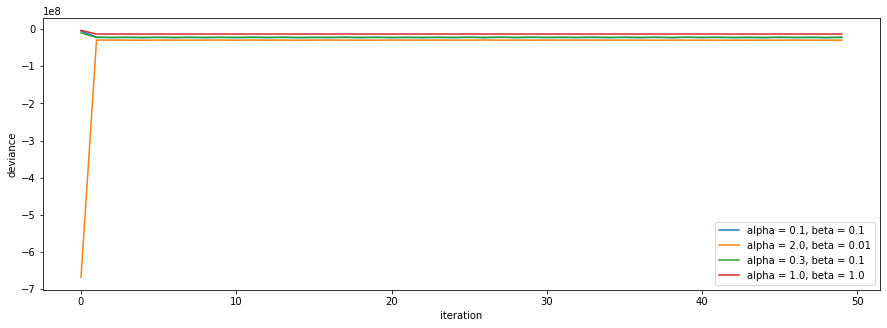

In [576]:
deviances = [[state[-1] for state in chain] for chain in chains]
# print(deviances)
fig,ax = plt.subplots(1,1,figsize=(15,5))
for c,d in enumerate(deviances):
    ax.plot(d, label=f"alpha = {ab_init[c][0]}, beta = {ab_init[c][1]}")
ax.set_xlabel('iteration')
ax.set_ylabel('deviance')
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# textstr = '\n'.join([r'$\alpha$ = {0}'.format(1.0),r'$\beta$ = {0}'.format(.1), 'K = 4'])
# ax.text(0.9,0.8,textstr, fontsize=14, transform=ax.transAxes, verticalalignment='top',bbox=props)
plt.legend()
plt.savefig('convergent1.png')

[449]
[449]
[156 199  94]
[  2 447]


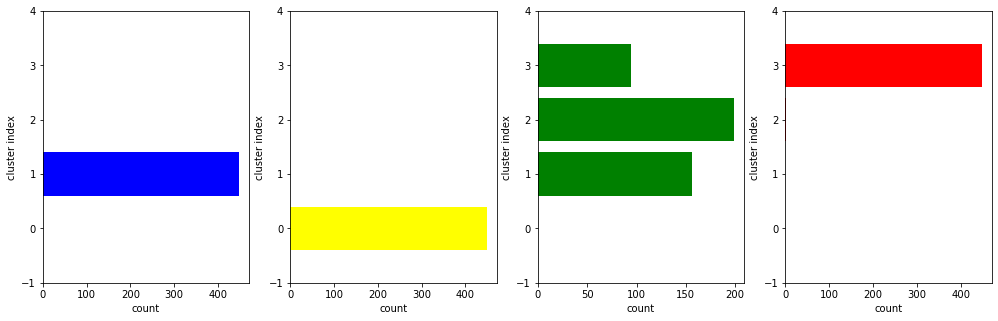

In [629]:
zeds = [chain[-1,2] for chain in np.array(chains)]
# print(zeds[0])
fig,ax = plt.subplots(1,4,figsize=(17,5))
colors = ['b','yellow','g','r']
yticks = [-1,0,1,2,3,4]
for i,z in enumerate(zeds):
    u,c = np.unique(z,return_counts=True)
    print(c)
    ax[i].barh(u,c, color=colors[i])
    ax[i].set_xlabel("count")
    ax[i].set_ylabel("cluster index")
    ax[i].set_yticks(yticks)
plt.savefig('convergent assignments')    

In [228]:
for i in range(3):
    with open(f'states_100_1_point1_chain_{i}', 'rb') as f:
        s = pickle.load(f)
        devs[i] = [x[-1] for x in s]

In [580]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

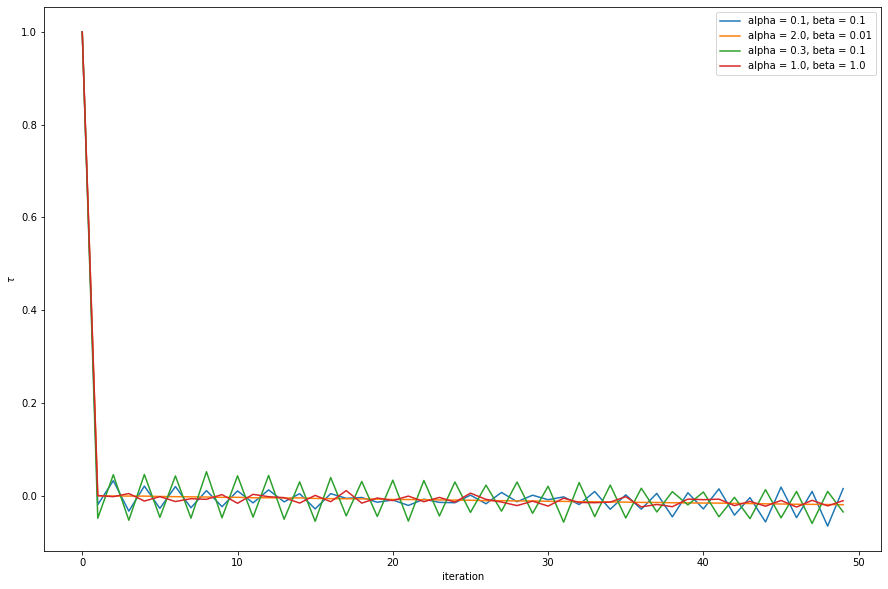

In [625]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
for i,d in enumerate(deviances):
    ac = autocorr_func_1d(d)
    plt.plot(ac, label=f"alpha = {ab_init[i][0]}, beta = {ab_init[i][1]}")
ax.set_xlabel('iteration')
ax.set_ylabel(r'$\tau$')
plt.legend()
plt.savefig('ac')

In [247]:
import pickle
for i,chain in enumerate(states):
    a = ab_init[i,0]
    b = ab_init[i,1]
    with open(f'states_{d_in}_{n_iter}_{a}_{b}_chain_{i}', 'wb') as f:
        pickle.dump(chain,f)

In [234]:
with open('states_20_1000_1_point1', 'rb') as f:
    s_old = pickle.load(f)